Import the Dependencies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import transforms,datasets

Inside the transform.Compose "pipeline" we convert the images of Cifar10 which comes in PIL format to pytorch tensors using transforms.ToTensor.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

Download of the (train)CIFAR10 dataset and creation of batches of 64 images(shuffled).

In [3]:
dataset = datasets.CIFAR10(root="./data",train=True,download=True,transform=transform)
train_batch = DataLoader(dataset,batch_size=64,shuffle=True)

Creation of the function to initialize the parameters W & B of each kernel.\
Here the "filters" will be the amount of kernels that we gonna have in each conv2d layer.\
The "channels" parameter because we're using kernels that are tensor3d with height,width and depth.The amount of channels will change,for example,the first(before enter the conv2d layer)will be 3(RGB) and then the amount will change representing every channel a feature map(basically is one feature map per kernel of the previous conv2d layer).\
And the kernel_size is how big the kernel in terms of height and width it gonna be,in this model i'll use a 3x3 kernel size.

In [ ]:
def init_conv2_params(filters,channels,kernel_size):
    
    fan_in = channels*kernel_size*kernel_size

    Wconv = np.random.randn(filters,channels,kernel_size,kernel_size) * np.sqrt(2/fan_in)

    Bconv = np.zeros((filters))

    return Wconv,Bconv

We initialize the parameters giving the respective arguments.\
I gonna use 4 conv2d layers giving to my CNN an architecture of:

Conv2d->ReLU\
Conv2d->ReLU\
Maxpooling

Conv2d->ReLU\
Conv2d->ReLU\
Maxpooling

Flatten

In [ ]:
W1,B1 = init_conv2_params(16,3,3)
W2,B2 = init_conv2_params(32,16,3)
W3,B3 = init_conv2_params(64,32,3)
W4,B4 = init_conv2_params(128,64,3)

This is the function for each Convolutional Layer in this Neural Network.\
Breaking it down:

We declare the function setting up the parameters which will be the batch of images(images),the kernels and its respective weights(kernels),the bias of each kernel(Bias) and some fixed parameters: The padding that we gonna give to each image(Padding=1) and the step that each image should do(Stride=1). 

The first part of the block of code is the if statement,it will detect if the batch of images is a pytorch tensor and if it is detach it from its "mathematical obligations" being an pytorch tensor and "move it" to the cpu for us,so we can convert it to a numpy tensor.

Next we take the shape of the Batch an kernels so we can work with each variable individually.

Then make the variables that represent the height and width of each image that gonna leave the function,this being 32x32 (without padding it would be something like 30x30 because it don't reach the borders and shrinks the resolution).\
Comment:the "+1" at the final of the line is just because the kernel start counting after it make the first move but the actual first position is BEFORE it moves so the +1 represent the initial position.That's it.

The variable "out" will be the "new batch" that gonna leave the conv2d function.It could be interpretered as an empty box in which we will put the results of each image after going through every kernel in the layer.

After all this preparation here is the nested loop:

1-This for loop will pass for every image of the batch and it will be padding each one of the images.\
2-This for loop will make the image pass through every filter(kernel).\
3-This for loop is just to travel all the height of the image.\
4-This for loop is have the same goal as the for loop of the height but the important difference here is the order in which we gonna travel through the image,this being first left to right then up to down(for every full pass left to right we move a little bit down and make another full pass).

Now the explanation of what we do in every cycle:

In these CNNs we usually say that every kernel scans every "little part" of the image and call the "little part" as "window" or "patch".\
Well in reality we take the patch of the image and "Swap it" through the weights of the kernel(Like a Credit Card),each kernel have its own weights that have the same dimensions than the patch,so it will give us a "new patch" this being modifier by the weights and bias of each kernel,so finally when we go through the entire image with the same kernel it will give us a Feature Map,that represent the previous image modified by the kernel,this image will have the same height and width in this case because we've used padding.

In the code we have exactly that,the start and end of the height and width of every patch corresponding to the current position of the loop.\
The patch which will take a portion of the image padded of the size previously mentioned.\
And then the storage of the patch "modified" by the kernel in our new empty box previously declared.

In [4]:
def foward_conv2d(images,kernels,Bias,Padding=1,Stride=1):

    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()

    batch_size,channel,h_in,w_in = images.shape
    filters,channels,kh,kw = kernels.shape

    h_out = (h_in - kh + 2*Padding) // Stride + 1
    w_out = (w_in - kw + 2*Padding) // Stride + 1

    out= np.zeros((batch_size,filters,h_out,w_out))

    for x in range(batch_size):
        img = images[x]
        img_padded = np.pad(img,((0,0),(Padding,Padding),(Padding,Padding)),mode="constant")
        for f in range(filters):
            for h in range(h_out):
                for w in range(w_out):
                        
                        w_start = w * Stride 
                        w_end = w_start + kw

                        h_start = h * Stride
                        h_end = h_start + kh

                        patch = img_padded[:,h_start:h_end,w_start:w_end]

                        out[x,f,h,w]= np.sum(patch * kernels[f]) + Bias[f]

    return out
        

Classic ReLU to make the negative values "turn off" so we only work with the positive values.\
But with a plus that we set the variable "cache" to be like the input that enters the ReLU function,so then we can use it in the backpropagation of the Convolusional Layers being this cache something similar to the mask of the maxpooling but "lighter" in computational terms.

In [5]:
def ReLU(X):
    cache = X 
    return np.maximum(0,X),cache

Here i'ma apply a maxpooling function,this will help us to use less computational power in the long run, simplifying the resolution of each image by exactly 50%.\
In terms of coding is basically the same as the conv2d layer,but it has some functional changes:

Kelnel :In comparation with the kernel of the convolutional layer this kernel doesn't have any weight or bias,it's only function is to detect(in the quadrant that we select,in this case 2x2 pixels) the highest value and return a 1x1 with that number,eliminating the others smaller values in the quadrant selected.


Stride :Previously in the conv2d layer we've used an Stride of 1.In this case the Stride will be of 2,this combining with the new size and purpose given to the kernel makes that we can get the desire output size of the image after going through maxpooling.

Mask :This is required only for the back propagation of the convolutional layers.Is a tensor4d with the same size of the Input of the function but instead of Numerical Values we use Boolean Values,we need to keep this information when we do the foward pass because it will tell us in the moment of the back propagation where the max_value was in order to pass the gradient to the correct "spot".


In [6]:
def maxpooling(Input,pool_h=2,pool_w=2,Stride=2):

    batch_size,channels,h_in,w_in = Input.shape

    h_out = (h_in - pool_h) // Stride + 1
    w_out = (w_in - pool_w) // Stride + 1

    out = np.zeros((batch_size,channels,h_out,w_out))

    mask = np.zeros_like(Input, dtype=bool)

    for x in range(batch_size):
        for c in range (channels):
            for h in range (h_out):
                for w in range(w_out):

                    h_start = h * Stride
                    h_end = h_start + pool_h

                    w_start = w * Stride
                    w_end = w_start + pool_w

                    patch = Input[x,c,h_start:h_end,w_start:w_end]

                    max_value = np.max(patch)
                    out[x,c,h,w] = max_value

                    mask[x,c,h_start:h_end,w_start:w_end] += (patch == max_value)
    return out,mask

    

Normally inside the Foward Pass of a CNN you can see 2 separated "regions".\
The first one being the "region" where the convolution happens,the convolutional layers, And the other "region" that is in almost every classification model you can find, the FC(fully-connected) layers.

Now what this matter in the explanation of this function?

Because we can see this function like a gate or portal that transforms a tensor into another tensor.\
At first in the convolutional part we work with tensors4d (batch_size,channels,height,width),now after the flatten we have got a tensor1d(64,128 * 8 * 8)because with the flatten we collapse the dimensions,this being exactly what we needed for the fc layers to work.



In [7]:
def flatten(tensor_in):
    flatten_tensor = tensor_in.reshape(tensor_in.shape[0],-1)
    return flatten_tensor

Initialization of the FC layers parameters,the change in the function with respect to the initialization of the conv2d parameters is in the dimensions.\
This function creating weights as a tensor2d and every neuron getting it's own personal bias.

In [ ]:
def init_fc_params(neurons,flatten):

    Wfc = np.random.randn(flatten,neurons) * np.sqrt(2/flatten)

    Bfc = np.zeros((neurons))

    return Wfc,Bfc

For us to initialize the parameters of the FC layers we need to know the dimensions of the flatten in order to pass it to the init_fc_params function.\
For that reason we use a "batch dummy"(which is a tensor imitating an image of cifar10) and pass it through the convolutional part of our CNN,at the end we just need to measure the shape of the final result.\
We use this to make a more modular CNN model,because if we use a different dataset or training method the dimensions may change.\
So in order to prevent that we just can run this cell with the respective size of "batch dummy" and always know the dimension that we would get when we collapse it to flatten it.

In [ ]:
flatten_dim = np.zeros((1,3,32,32))
flatten_dim = foward_conv2d(flatten_dim,W1,B1)
flatten_dim = foward_conv2d(flatten_dim,W2,B2)
flatten_dim,cache = ReLU(flatten_dim)
flatten_dim,mask = maxpooling(flatten_dim)

flatten_dim = foward_conv2d(flatten_dim,W3,B3)
flatten_dim = foward_conv2d(flatten_dim,W4,B4)
flatten_dim,cache = ReLU(flatten_dim)
flatten_dim,mask= maxpooling(flatten_dim)

print(flatten_dim.shape)

flatten_size = np.prod(flatten_dim.shape[1:])
print(flatten_size)

Now we can call the function to initilize our parameters of the FC layers

In [ ]:
W5,B5 = init_fc_params(128,flatten_size) 
W6,B6 = init_fc_params(10,128)

This is the Softmax function to get the final prediction of our model giving to this funcion the Z6 that we got in the final sum of our foward pass,for a more formal explanation I encourage you to check the NN from scratch using the dataset of MNIST in my github.

In [8]:
def Softmax(Z2):

    shifted = Z2 - np.max(Z2,axis=1,keepdims=True)

    scores = np.exp(shifted)

    preds = scores / np.sum(scores,axis=1,keepdims=True)

    return preds

This is the other "region" that I talk about earlier, is the most common part of the Neural Networks.\
We take the flatten version of our batch which will have a dimension of (64,8192) and multiply them by the weights of dimensions(8192,128) at the end we just sum the bias corresponding to every neuron so we can get a Z5 of dimensions(64,128) to then giving them to the ReLU function to get the activation of everyone(A5).\
Now we do the same process but instead of using flatten we use the A5(64,128) and multiply it by the weights(128,10),sum them with the bias of each neuron and getting the Z6(64,10).\
Then Just pass it to the Softmax function and getting the preddiction of the model as A6.\
After that we return Z5,A5,Z6,A6 because we will need it to calculate the back propagation and update de parameters.

In [9]:
def foward_fc(W5,B5,W6,B6,flatten):

    Z5 = flatten @ W5 + B5
    
    A5,cache5 = ReLU(Z5)

    Z6 = A5 @ W6 + B6

    A6 = Softmax(Z6)

    return Z5,A5,Z6,A6

I need to clarify that this function is not extrictly needed as it doesn't has any influence in the training of the model.\
But is important because if we don't have it we gonna be training the model blind.Without this function we don't have access to know how good is the model improving and we can't know when to stop it,playing with the risk of overfitting.\
So this fuction is like the control panel of the model.

In the function we have if statements,for us to be sure that we're working with numpy tensors.\
Then a variable to know the batch size (64 in this case,we don't hardcode "64" in order to make the function modular).\
Now the correct_answers variable contains the values of the correct class according to the labels.\
After that we declared an special number because in the next step we gonna declare the "logs" variable that gets the -log values of the correct_ans variable and we need to add this special number.It will help to maintain a certain minimum value,because computers tends to take as a 0 the values that go too low and that is also a thing we don't want.\
At the end we just return the mean value of the loss of the entire batch.

In [10]:
def cross_entropy_loss(predictions,labels):

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
        
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()

    batch_size = predictions.shape[0]

    correct_ans = predictions[np.arange(batch_size),labels]

    spe_num=1e-12

    logs = -np.log(correct_ans + spe_num)

    return np.mean(logs)

This function is the backpropagation of the FC layers which will give us the gradient of every parameter in the fc layer according to the true prediction that it should give us.

First we take the predictions and make a copy of it,so we don't mess the model's predictions and we can keep working.\
Second we compare the prediction with the onehot encoding of the true values,previously in the NN of MNIST I have made a function to get the onehot encoding,but this is a more professional way of doing it(no new functions,only one line of code,using the same trick of the advance indexing of numpy,also used in the loss function).

Now that we have the dZ6 which is of much of error the predictions of the model has we can do back propagation to get each parameter:

dW6 = Is the diference between A5 and Z6 of the foward pass(because of the weights in that part),so we got A5 transposed(64,128 -> 128,64) and dZ6(64,10),the dot product of that will be how much of influence had the weights there.

dB6 = Is just the summatory of all the errors of each image of the batch in that layer.

dA5 = Is the derivative of the activation of the hidden layer so in order to get the derivative of the weights and bias of W5 and B5 we need to know how A5 has contributed in the foward pass,the formula to get it is just following the chain rule.getting the dot product of dZ6(64,10)by the W6 transposed(128,10 -> 10,128) = dA5 = (64,128)

dReLU = This is the derivative of ReLU which we need to "cut" the backpropagation(stop the backpropagation where ReLU hasn't activated),it is just a matrix of the size of Z5 full of booleans,then transforms those booleans into float numbers.

dZ5 = This is the derivative of Z5 which is the multiplication(by element,for that reason is the " * " instead of the " @ ")of dA5 by dReLU,so dZ5 is basically dA5 (64,128) but thanks to dReLU some values are multiplied by 0 (so the values turns 0 stopping the back propagation there) and the values multiplied by 1 still intact. 

Now that we got dZ5 we can do the same process with the next layer:

dW5 = Is now the dot product of the flatten transposed(64,8192 -> 8192,64) by dZ5 (64,128) so dW5 is (8192,128)exactly the amount of weights of that layer.

dB5 = And this is again just a summatory of the errors in that layer.

dflatten = The final thing that we gonna do in the backpropagation of the FC layers is the derivative of the flatten,which is our input in the FC but just a connection between conv2d and fc layers.To get it is the same thing as the dA5, but instead of dZ6 and W6.T is dZ5 and W5.T.

In [11]:
def Back_propagation(predictions,labels,A5,Z5,W6,W5,flatten):

    batch_size = predictions.shape[0]
    # Making a copy so we don't break the results of the foward pass.
    dZ6 = predictions.copy() 

    # Softmax of the predictions - Onehot_encoding of the labels using the advance indexing of numpy.
    dZ6[np.arange(len(labels)),labels] -= 1
    dZ6 /= batch_size

    dW6 = A5.T @ dZ6

    dB6 = np.sum(dZ6,axis = 0)

    dA5 = dZ6 @ W6.T
    
    dReLU = (Z5 > 0).astype(float)
    
    dZ5 = dA5 * dReLU

    dW5 = flatten.T @ dZ5

    dB5 = np.sum(dZ5,axis = 0)

    dflatten = dZ5 @ W5.T
    
    return dZ6,dW6,dB6,dA5,dZ5,dW5,dB5,dflatten

Now that we got the derivative of the input of the FC layers we need to "unflattenize" it.\
The dflatten has the dimensions (64,8192) but we need the dimensions previous of the flatten function when we did the foward pass (64,128,8,8) in order for us to use it so we can keep calculating the gradients in the convolutional layers.

In [12]:
def unflattenize(dflatten,before_flatten_dim):

    dA_maxpooling = dflatten.reshape(before_flatten_dim)

    return dA_maxpooling

This is the back propagation of the maxpooling.\
Here we assign as parameter the derivative of the input layer of the FC layers with the dimensions previous of the flatten,the mask that we have saved in the foward pass and some fixed parameters that are the same as the maxpooling function of the foward pass.

First we take the shape of the dinput_unflattenized(also called "dout",but I'll use dinput_unflattenized for me to be easier to understand).\
Second we need to create a new tensor4d with the same size and dimensions as the mask and filll it out with float numbers(0.0).\
Then we have another nested loop, mostly when we have a nested loop in the CNNs it's just to do 3 things,take a "patch/window" every loop,do something with it (for example in the maxpooling of the foward pass we take the max_value of the patch) and then "save" that information in the tensor previously created.\
Here we declare the current gradient of the loop as a variable "current_gradient".\
Then take the current patch of the mask and multiply it by the current gradient,because the patch that we take is a 2x2 with 3 falses and 1 true(the position of the max_value before maxpooling being the true) and because is boolean it will represent it's values as 1 and 0,so when we multiply the gradient with the falses(0) those positions will have a 0 on it and the position of the true(1) will have the gradient,with that we have the gradient in the correct position and we can save it in the tensor4d of floats previously declared,returning that tensor.

In [13]:
def backprop_maxpooling(dinput_unflattenized,mask,h_pool=2,w_pool=2,stride=2):

    batch_size,channels,h_out,w_out = dinput_unflattenized.shape

    dInput = np.zeros_like(mask, dtype=float)

    for x in range(batch_size):
        for c in range(channels):
            for h in range(h_out):
                for w in range(w_out):

                    h_start = h * stride
                    h_end = h_start + h_pool

                    w_start = w * stride
                    w_end = w_start + w_pool

                    current_gradient = dinput_unflattenized[x,c,h,w]

                    dInput[x,c,h_start:h_end,w_start:w_end] += mask[x,c,h_start:h_end,w_start:w_end] * current_gradient

    return dInput

    

Here we use the cache variable that we have saved earlier in the foward pass.\
Declaring a new variable dx and using the the tensor that returns of the back propagation of the maxpooling function or backpropagation of the conv2d function (dOut) and multiply it by the boolean tensor with the same size as the cache tensor.\
Returning this new Tensor where only the "space" which the kernels have activated let pass the gradient.

In [14]:
def Backprop_ReLU(dOut,cache):
    dx = dOut * (cache > 0)
    return dx

Here we got the back propagation of the conv2d layers,we use the same principes as the linear backpropagation but like the foward past of the conv2d layer this will be by windows of the entire image, I'll explain what I mean by this:

First we declare the function and take as argument the following parameters:\
X: which is the input that enter the funcion in the foward pass of the respective step.\
dOut: which is the gradient that comes from "above"(after the backprop of ReLu).\
W: which is the Weights that had influence in the result of the foward pass.\
Stride: this is a fix parameter and the only purpose is to mark the size of the step in the convolution.

Explanation of the funcion:

We take the shape of every parameter,it will be usefull later.

And before continue to create the containers we need the correct form of X,because in the foward pass we have padded the images,so now we need to pad them again in order to travel across the entire image when we do te back propagation.

Now we create the "containers" this containers are tensor of zeros with it's respective form.\
dB: This container will have the same Shape as the channels of dOut because every feature map was influenced by 1 Bias so the amount of bias that gonna receive the gradient is equal to the amount of feature maps of the gradient(dOut).\
dW: This container will have the same shape as the W parameter(W is the tensor of the kernels),so every of the 27 weights of every kernel in the entire batch of kernels will have it's own gradient this resulting in a Tensor of the size of W.
dX: This container of zeros have the same shape as the X parameter because we gonna assign the respective error of every input in the function,so if every input have its error the tensor dX will have the same shape as X.

Like always when we have some convolution we use nested loops,this nested loop go along each image with it's respetives channels/feature maps,height and width.\
The first thing that we do is create the window of the convolution this window having the same size as the window of the convolution part of the layer.\
Then we set our variable grad,which is the gradient(dOut) and select the current value that is in the loop,this value is an escalar value.\
Then we have the X_slice variable which is the current window of X in the convolution.\
Now we are touching the containers fo the parameters:

dB: Will be the summatory of the error in each feature map,something similar to the FC backprop.\
dW: Will be the correlation of the X_slice and the gradient in each feature map,it will tell us how much every weights has contribued in every window of the feature map,so comparing the input with the error will give us the erro of the weights.
dX: This is one is the error of the input,analogicaly when the gradient come from above,it will distribute the blame of the results,first it will blame the weigths but once the weights are done,the next thing to blame for the poor result is the input of the previous layer,so the gradient "blames" the weights and the rest of the blame goes to the input.That part of the loop it's exactly that,"the chain rule",the error of the input(dX)its the summatory of every error of the input according to the travel of the weights through every part of the input and the respective error that we got from that part.\
Now our dX have the padding that we added before so after the function finished the loop we remove the padding outside the loop.

Then we just return the gradient of the parameters so we can actualize them later and dX being our new "dOut".

In [15]:
def backprop_conv2d(X,dOut,W,stride=1,padding=1):

    batch_size,channels,h_in,w_in = X.shape

    _,C_out,h_out,w_out = dOut.shape

    c_out,c_in,kh,kw = W.shape

    X_padded = np.pad(
        X,
        ((0,0),(0,0),(padding,padding),(padding,padding)),
        mode="constant"
    )

    dB = np.zeros(C_out)
    dW = np.zeros_like(W)
    dX = np.zeros_like(X_padded)

    for x in range(batch_size):
        for c in range(C_out):
            for h in range(h_out):
                for w in range(w_out):

                    h_start = h * stride
                    h_end = h_start + kh

                    w_start = w * stride
                    w_end = w_start + kw

                    grad = dOut[x,c,h,w]

                    X_slice = X_padded[x,:,h_start:h_end,w_start:w_end]
                    
                    dB[c] += grad
                    
                    dW[c] += X_slice * grad
                    
                    dX[x,:,h_start:h_end,w_start:w_end] += W[c] * grad
                    
    dX = dX[:,:,padding:-padding,padding:-padding]

    return dB,dW,dX

Here i'm traying something new for me,Classes.\
The class is named by the type of optimization (in this case),Stochastic Gradient Descent(SGD).\
First we have the init function which will "save" the data of our optimizer inside the class in their respective self.params or self.lr.\
Then we got the step function,which is the real actualization of parameters,the for loop inside the function will take each parameter with its respective gradient in the optimizer and grads previously saved and actualize it multiplying it by the learning rate declared in the optimizer that we pass earlier.

In [16]:
class SGD:

    def __init__(self,params,learning_rate):
        self.params = params
        self.lr = learning_rate

    def step(self,grads):
        for p,g in zip(self.params,grads):
            p -= self.lr * g

Declaration of how our optimizer will be:

We create a list with our parameters and pass it to the optimazer variable which will use those params inside the class SGD.

In [19]:
params = [W1,W2,W3,W4,W5,W6,
          B1,B2,B3,B4,B5,B6]

Optimizer = SGD(params, learning_rate = 0.01)

Here we declare the variables in where we gonna store the results of each pass of the train_data,the two variables are the loss of each epoch and the accuracy of each epoch,in order to then know how well it have trained and if something happend know where.Then we have the variable of epochs which is the amount of time that the train_data will pass through the model.
Lastly are the variables that let us stop the training process in case the model stop learning.
best loss is the current minimun batch loss,we initialize it with a infinite number so the first loss when we start training the model will be the best loss.\
patience is the amount of training loop without improvement that we can tolerate.\
And wait is the current amount of loops without improvements that we are in.

In [17]:
train_loss_history = []
train_acc_history = []
epochs = 20
best_loss = float("inf")
patience = 3
wait = 0
# Just to remember easier later in the future if I come back to this Notebook:
batch_size = 64
learning_rate = 0.01

And finally here is where the "magic" happens.
I'm going to explain the 2 for loops of the training:

EPOCH LOOP:

First we got the for loop of epochs(20 epoch in total).\
Because the training take an important amount of time we should save "checkpoints" of our progress,so the "start_epoch" in the loop is the last epoch of the training(the checkpoint)of the last time that we started the train loop.\
every loop we reset the variables batch_loss,correct_predictions and total examples.

Then we have the most important part,the batch loop that i'm gonna explain later.

At the bottom of the function,where the loop of epoch continues,we have 2 new variables(epoch_loss and epoch_acc),this variables represent, the loss after one pass of the entire train_data calculating the mean/average loss of each pass(epoch_loss),the other variable is the amount of correct prediction that our model can predict in a certain amount of tries(example: of every 10 images our model can tell us correctly 6 of them).\
Then we just append to our global variables(epoch_loss_history and epoch_acc_history) the respective value of each epoch.

Next in the epoch loop we have the early stopping that will help us stop the model if it stop learning for 3 consecutives epochs.

BATCH LOOP:

Inside the epoch loop we find the batch loop which is a loop through batches of 64 images of the train_data giving us the variables images and their corresponding labels.

Previously I have said that our model will have this Architecture:

(Convolutional layers -> Flatten -> FC Layers)

#---CONVOLUTIONAL LAYERS---#\
Images

Conv2d -> ReLU.\
Conv2d -> ReLU.\
Maxpooling.

Conv2d -> ReLU.\
Conv2d -> ReLU.\
Maxpooling.\
#--------------------------#

Flatten

#---FULLY-CONNECTED LAYERS---#\
Hidden Layer.

Output Layer.\
#----------------------------#

This is exactly what we represent in the code.\
When we finish the foward pass is the correct time to calculate the loss of the batch.So we calculate the lost,and append the result to our batch_loss variable.Then we see how many predictions we got correct comparing the index of the tensor outputed by our model and the tensor of labels if it match,the answer is correct.And lastly we sum the amount of samples of the batch(64) to our total_samples variable.

I have explaining pretty much everything through the declaration of the functions and how they are used in training so i don't want to be redundant.\
I'll jump straight to the variable of type list that change every loop of teh batch.The variable of grad is required for the actualization of the parameters,is a list of all the gradients of the weights and biases,list that we will pass to the step function inside our SGD class to zip it with their respective weights so then we can multiply it with the learning rate and update the weights and biases for the next loop.

Lastly we have the autosave inside the batch loop with the condition of every 50 batches save the current weights and bias.

In [20]:
for epoch in range(start_epoch,epochs):
    batch_loss = []
    correct_predictions = 0
    total_samples = 0

    for batch_idx,(images,labels) in enumerate(train_batch):

        #--Foward Part--
        
        out1 = foward_conv2d(images,W1,B1)
        Rout1,cache1 = ReLU(out1)
        out2 = foward_conv2d(Rout1,W2,B2)
        Rout2,cache2 = ReLU(out2)
        pooled,mask1= maxpooling(Rout2)

        out3 = foward_conv2d(pooled,W3,B3)
        Rout3,cache3 = ReLU(out3)
        out4 = foward_conv2d(Rout3,W4,B4)
        Rout4,cache4 = ReLU(out4)
        pooled,mask2 = maxpooling(Rout4)

        flat = flatten(pooled)

        Z5,A5,Z6,A6 = foward_fc(W5,B5,W6,B6,flat)

        #--Loss part --
        
        loss = cross_entropy_loss(A6,labels)
        batch_loss.append(loss)

        preds = np.argmax(A6, axis=1)
        labels_np = labels.detach().cpu().numpy()

        correct_predictions += np.sum(preds == labels_np)
        total_samples += labels.shape[0]

        
        #--Backprp part--
        
        _,dW6,dB6,_,_,dW5,dB5,dflatten = Back_propagation(A6,labels,A5,Z5,W6,W5,flat)

        unflat = unflattenize(dflatten,pooled.shape)

        dOut = backprop_maxpooling(unflat,mask2)
        dRout = Backprop_ReLU(dOut,cache4)
        dB4,dW4,dOut = backprop_conv2d(Rout3,dRout,W4)
        dRout = Backprop_ReLU(dOut,cache3)
        dB3,dW3,dOut = backprop_conv2d(Rout2,dRout,W3)

        dOut = backprop_maxpooling(dOut,mask1)
        dRout = Backprop_ReLU(dOut,cache2)
        dB2,dW2,dOut = backprop_conv2d(Rout1,dRout,W2)
        dRout = Backprop_ReLU(dOut,cache1)
        dB1,dW1,dOut = backprop_conv2d(images,dRout,W1)

        grads = [dW1,dW2,dW3,dW4,dW5,dW6,
                 dB1,dB2,dB3,dB4,dB5,dB6]

        Optimizer.step(grads)

        #---Autosave(because the training take a lot of time)---
        if batch_idx % 50 == 0:
            
            print(f"Epoch {epoch} | Batch {batch_idx}/{len(train_batch)} | Loss {loss:.4f}",
                  flush=True   
                 )

            np.savez(
                "checkpoint_cifar10.npz",
                W1=W1, B1=B1,
                W2=W2, B2=B2,
                W3=W3, B3=B3,
                W4=W4, B4=B4,
                W5=W5, B5=B5,
                W6=W6, B6=B6,
                epoch=epoch,
                batch=batch_idx,
                train_loss_history=train_loss_history,
                train_acc_history=train_acc_history
            )

    epoch_acc = correct_predictions / total_samples
    epoch_loss = np.mean(batch_loss)

    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)

    print(f"Epoch N°{epoch+1}of{epochs} | Loss : {epoch_loss} | Accuracy : {epoch_acc}")

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        wait = 0
    else:
        wait += 1
        if wait == patience:
            print("💥 Early Stopping Activated 💥")
            break

Epoch 4 | Batch 0/782 | Loss 2.0580
Epoch 4 | Batch 50/782 | Loss 2.5428
Epoch 4 | Batch 100/782 | Loss 2.1119
Epoch 4 | Batch 150/782 | Loss 1.5696
Epoch 4 | Batch 200/782 | Loss 1.6363
Epoch 4 | Batch 250/782 | Loss 1.7802
Epoch 4 | Batch 300/782 | Loss 1.6389
Epoch 4 | Batch 350/782 | Loss 1.5758
Epoch 4 | Batch 400/782 | Loss 1.5867
Epoch 4 | Batch 450/782 | Loss 1.5044
Epoch 4 | Batch 500/782 | Loss 1.5399
Epoch 4 | Batch 550/782 | Loss 1.5567
Epoch 4 | Batch 600/782 | Loss 1.4040
Epoch 4 | Batch 650/782 | Loss 1.5152
Epoch 4 | Batch 700/782 | Loss 1.5681
Epoch 4 | Batch 750/782 | Loss 1.5682
Epoch N°5of20 | Loss : 1.6610521072455953 | Accuracy : 0.40974
Epoch 5 | Batch 0/782 | Loss 1.6303
Epoch 5 | Batch 50/782 | Loss 1.6102
Epoch 5 | Batch 100/782 | Loss 1.5034
Epoch 5 | Batch 150/782 | Loss 1.7168
Epoch 5 | Batch 200/782 | Loss 1.3320
Epoch 5 | Batch 250/782 | Loss 1.4851
Epoch 5 | Batch 300/782 | Loss 1.3607
Epoch 5 | Batch 350/782 | Loss 1.2867
Epoch 5 | Batch 400/782 | Loss 

KeyboardInterrupt: 

This is a manual save(manual checkpoint),I only used the first time because I was in a hurry and I needed to save the progress,now it is actually not needed because we have the autosave inside the batch loop which is better than the manual,but I'll leave it here because is "history" of the creation of the CNN.

In [ ]:
np.savez(
    "checkpoint_cifar10.npz",
    W1=W1, B1=B1,
    W2=W2, B2=B2,
    W3=W3, B3=B3,
    W4=W4, B4=B4,
    W5=W5, B5=B5,
    W6=W6, B6=B6,
    epoch=epoch,
    train_loss_history=train_loss_history,
    train_acc_history=train_acc_history
)


Here is the loader of the last checkpoint,this cell must be runned before start the training loop in order to have the weights an biases of the last training.

In [18]:
checkpoint = np.load("checkpoint_cifar10.npz")

W1 = checkpoint["W1"]; B1 = checkpoint["B1"]
W2 = checkpoint["W2"]; B2 = checkpoint["B2"]
W3 = checkpoint["W3"]; B3 = checkpoint["B3"]
W4 = checkpoint["W4"]; B4 = checkpoint["B4"]
W5 = checkpoint["W5"]; B5 = checkpoint["B5"]
W6 = checkpoint["W6"]; B6 = checkpoint["B6"]

start_epoch = int(checkpoint["epoch"]) + 1

train_loss_history = checkpoint["train_loss_history"].tolist()
train_acc_history = checkpoint["train_acc_history"].tolist()

print(f"Resuming from epoch {start_epoch}")


Resuming from epoch 4


This shows the Loss per Epoch.\
Due to restart of the kernel in epoch 3 model weights were restored from saved checkpoint but the epoch_loss_history was vanished(they not persisted through the restart),this metric reports loss value from epoch 4 onward.\
Despite this it shows a decresing trend in loss per epoch which means that the Model was effectively learning.

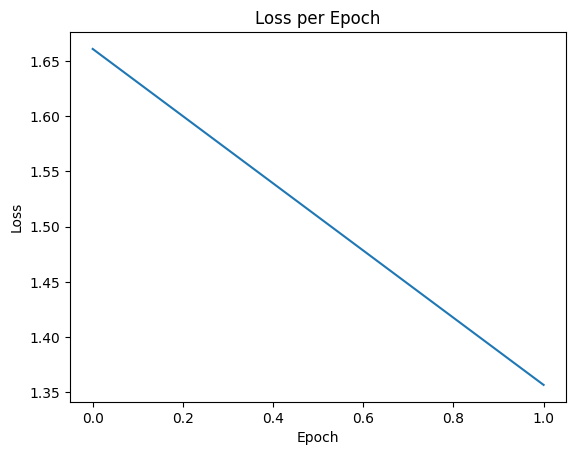

In [21]:
plt.figure()
plt.plot(train_loss_history)
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Like the train_loss_history, the train_acc_history also was affected by the restart of the kernel, losing its values before epoch 4 meaning that this metric is truncated but useful to see that the Model has increased it's accuracy consistenly in training.

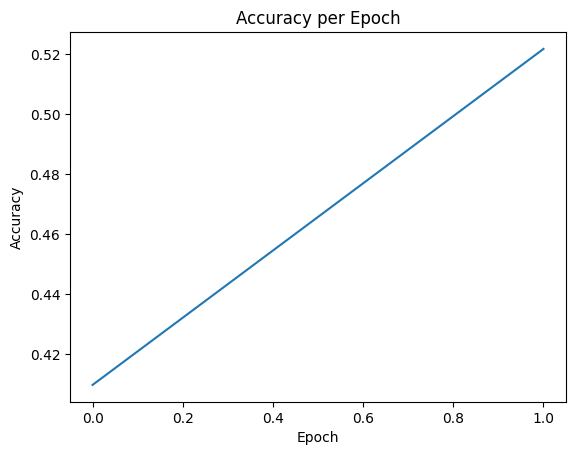

In [22]:
plt.figure()
plt.plot(train_acc_history)
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

We prepare the test dataset for the foward pass and later evaluation of result.

In [23]:
testset = datasets.CIFAR10(root="./data",train=False,download=True,transform=transform)
test_data = DataLoader(testset,batch_size=64,shuffle=True)

Variables for us to measure after the foward pass of the test dataset.

In [24]:
correct_predicts = 0
total_samples = 0
wrong_examples = []
max_wrong_store = 20
correct_examples = []
max_correct_store = 10

class_names = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

The test dataset(batches of 64 images in a total of 10000 images) goes through the foward pass using the weights and bias learned.


Test loop executed once.\
The following cells reuse stored results to avoid recomputation.

In [25]:
for x_test, y_test in test_data:
    
    out1 = foward_conv2d(x_test,W1,B1)
    Rout1,_ = ReLU(out1)
    out2 = foward_conv2d(Rout1,W2,B2)
    Rout2,_ = ReLU(out2)
    pooled,_= maxpooling(Rout2)

    out3 = foward_conv2d(pooled,W3,B3)
    Rout3,_ = ReLU(out3)
    out4 = foward_conv2d(Rout3,W4,B4)
    Rout4,_ = ReLU(out4)
    pooled,_ = maxpooling(Rout4)

    flat = flatten(pooled)

    Z5,A5,Z6,A6 = foward_fc(W5,B5,W6,B6,flat)

    predicts = np.argmax(A6, axis=1)
    
    y_test_np = y_test.detach().cpu().numpy()

    
    
    #this loop stores 20 wrong and 10 correct to show later using matplotlib
    for i in range(y_test_np.shape[0]):
        
        if predicts[i] != y_test_np[i]:
            if len(wrong_examples) < max_wrong_store:
                wrong_examples.append((
                    x_test[i].detach().cpu().numpy(),
                    y_test_np[i],
                    predicts[i]
                ))
            
        else:
            if len(correct_examples) < max_correct_store:
                correct_examples.append((
                    x_test[i].detach().cpu().numpy(),
                    y_test_np[i],
                    predicts[i]
                ))


    
                    
    correct_predicts += np.sum(predicts==y_test_np)

    total_samples += y_test_np.shape[0]
    

The correct predictions and the errors of the model:

In [26]:
total_corrects = correct_predicts / total_samples
print(f"Test accuracy: {total_corrects:.4f}")
print(f"Total errors: {total_samples - correct_predicts}")

Test accuracy: 0.5549
Total errors: 4451


Visualization of the Wrong Predictions given by the model:

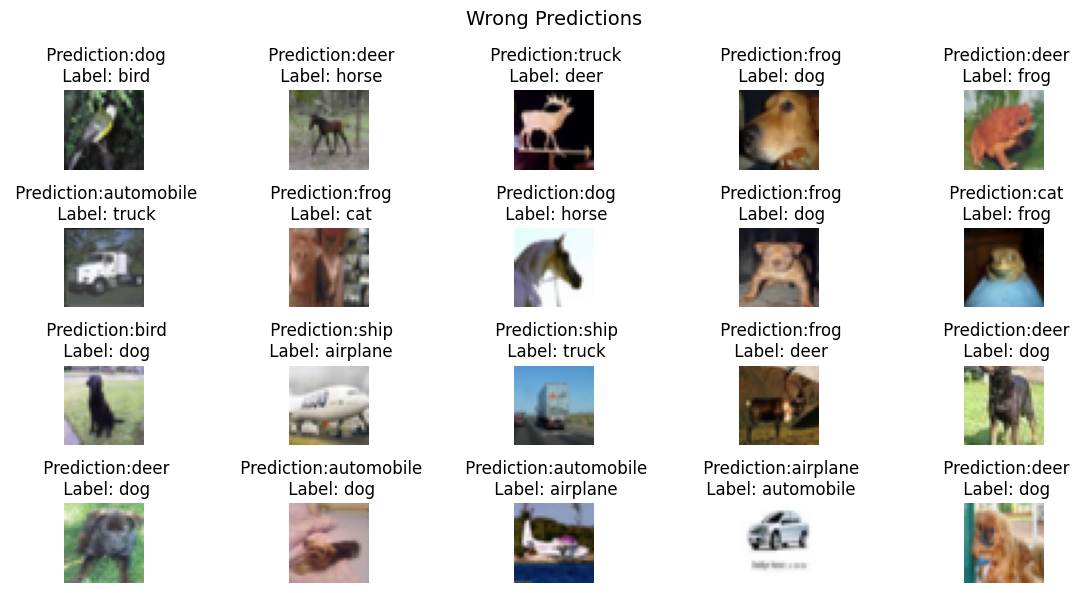

In [34]:
plt.figure(figsize=(12,6))


for i,(img,true_label,pred_label) in enumerate(wrong_examples):
    plt.subplot(4,5,i+1)

    img = img.transpose(1,2,0)

    plt.imshow(img)
    plt.title(f" Prediction:{class_names[pred_label]}\n Label: {class_names[true_label]}")
    plt.axis("off")

plt.suptitle("Wrong Predictions",fontsize=14)
plt.tight_layout()
plt.show()

Visualization of the Correct Predictions given by the model:

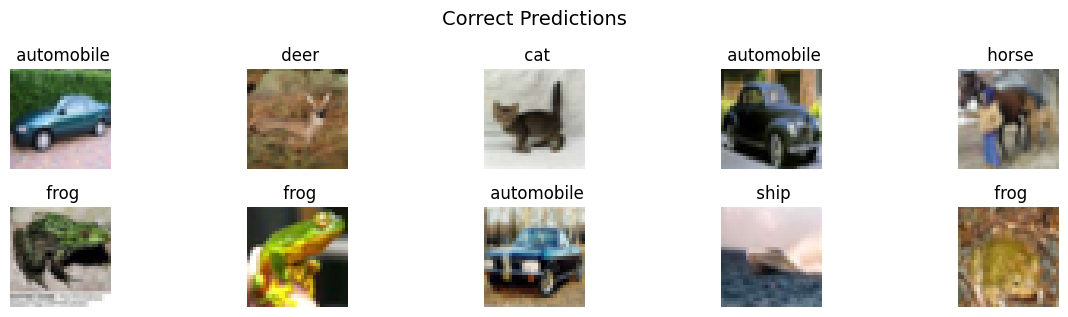

In [35]:
plt.figure(figsize=(12,6))

for i,(img,true_label,pred_label) in enumerate(correct_examples):
    plt.subplot(4,5,i+1)

    img = img.transpose(1,2,0)

    plt.imshow(img)
    plt.title(f" {class_names[true_label]}")
    plt.axis("off")

plt.suptitle("Correct Predictions",fontsize=14)
plt.tight_layout()
plt.show()